Len of input data: 49774
| Data statistics 
total entries: 30000

stat	r_mag	g-r	u-g	r-i	
min	0.000	0.000	0.000	0.000	
max	1.000	1.000	1.000	1.000	
mean	0.443	0.845	0.578	0.379	
median	0.461	0.855	0.583	0.380	
std	0.219	0.056	0.055	0.038	
| SOM. Step 0. Initialization: random


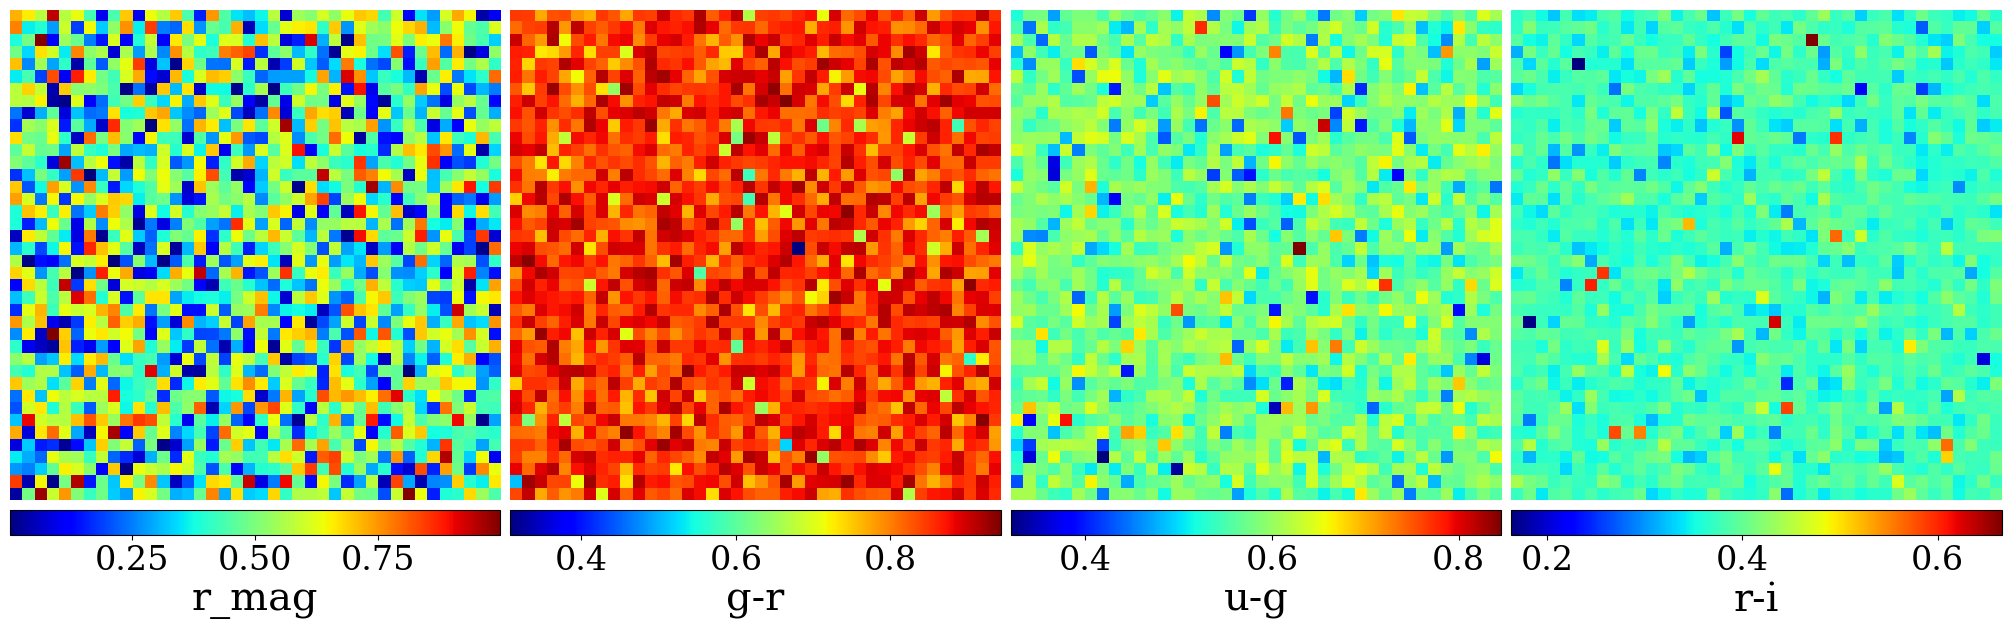

In [49]:
from astropy.io import fits
from astropy.table import Table

import numpy as np
import matplotlib.pyplot as plt

#Load in data
data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_08Jul24.fits'

with fits.open(data_file) as cat:
    input_catalog_complete = Table(cat[1].data)

#Select the needed data
import numpy as np
input_labels     = input_catalog_complete['r_mag','gr_col', 'ug_col', 'ri_col', 'log_mstar', 'redshift']
input_label_stds = input_catalog_complete['r_mag_err', 'gr_col_err', 'ug_col_err', 'ri_col_err']

tuple_labels = input_labels.as_array()
list_labels  = [list(values) for values in tuple_labels]
input_labels = np.array(list_labels)

print(f'Len of input data: {len(input_data)}')

from mpdg_som import SelfOrganizingMap

#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [40, 40] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'random' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.95 #used to adjust the learning rate function
kernel_spread = 16.5 #used to adjust the neighborhood function
maximum_steps = 10 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.01 #used to stop the SOM if termination = 'error thresh'

#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

data_cut = 30000 #use up to this much of the data (-1 for entire dataset)
randomized_idx = np.arange(0, len(input_data))
np.random.shuffle(randomized_idx)
randomized_data_idx  = randomized_idx[:data_cut]
randomized_label_idx = randomized_idx[data_cut:]

SOM.load_data(input_data[randomized_data_idx],
              variable_names = ['r_mag', 'g-r', 'u-g', 'r-i'])#, 'u-r'])
SOM.normalize_data()

SOM.load_standard_deviations(input_stds[randomized_data_idx])
SOM.normalize_standard_deviations()

SOM.data_statistics()

SOM.build_SOM()

#Load trained map instead
# SOM.weights_map = np.load('/data2/lsajkov/mpdg/saved_soms/10Jul24/SOM_weights.npy',
#                           allow_pickle = True)
# SOM.step = 10

#Visualize the SOM after training
SOM.show_map(cmap = 'jet')

In [58]:
SOM.train()

Step 5 complete. Error: 0.103                                   
Step 6 complete. Error: 0.090                                   
Step 7 complete. Error: 0.099                                   


KeyboardInterrupt: 


| SOM. Step 7. Initialization: random


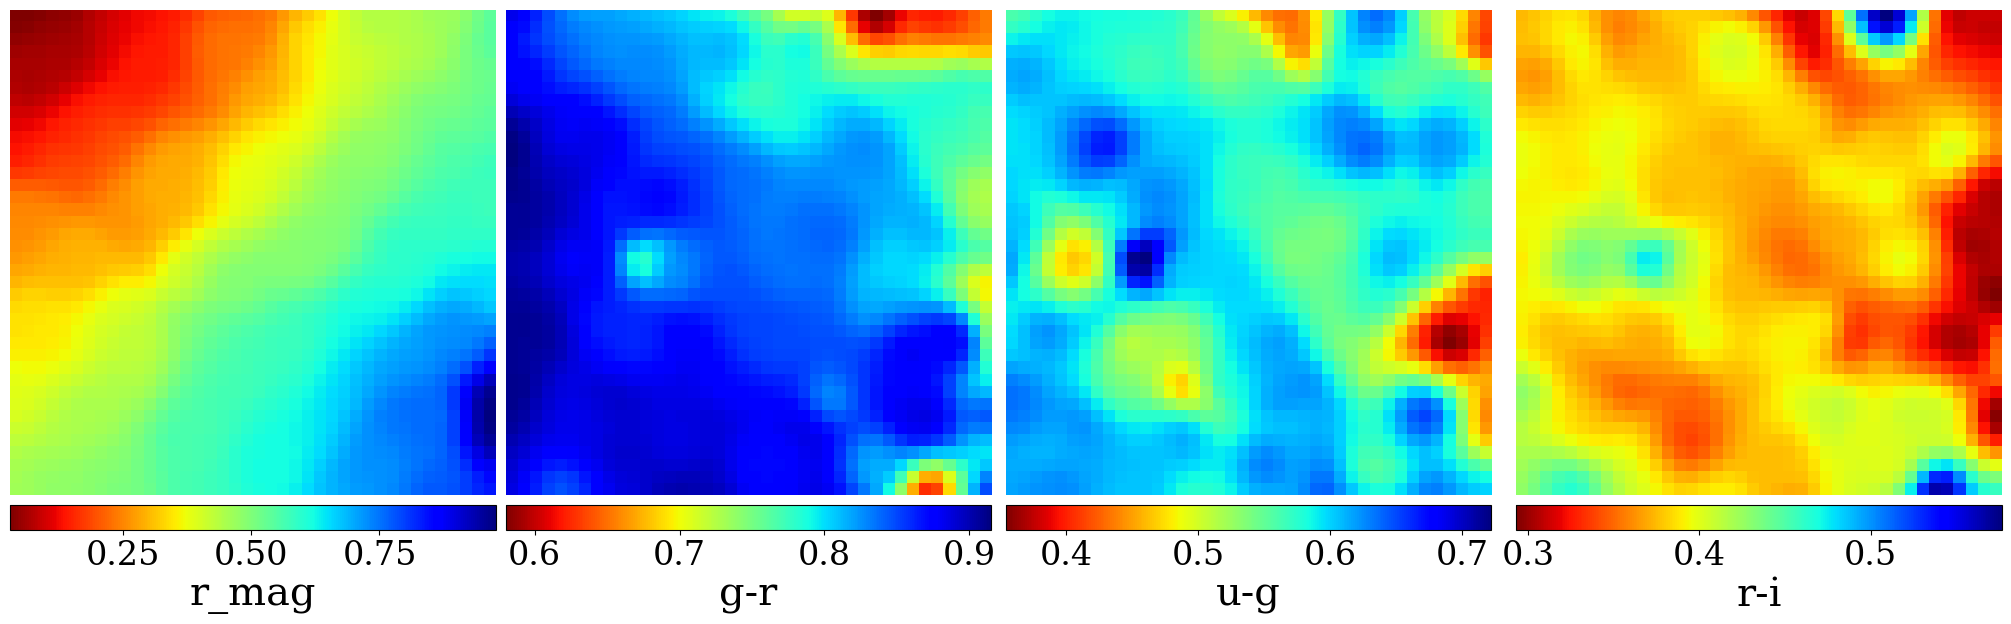

In [59]:
SOM.show_map()

In [55]:
from mpdg_som_utils import find_bmu_coords

In [60]:
def label_map(self,
              sigmas_data: list = None,
              sigmas_add: list = None,
              pdr: int = 1000,):

        self.pdr = pdr
        #pdr = probability density resolution

        #initialize the labeled map as a probability distribution for each variable in each cell
        #the complete map will have (number of variables * number of cells) probability distributions
        #the distributions are initialized with p(var|obs) = 0.0, where var is the given variable and obs is an observed value
        labeled_map = np.zeros([*self.mapsize, self.labels_dim, pdr])

        #create the viable distribution space. This is essentially the integration bounds where var can be non-zero
        distribution = np.array([np.linspace(np.min(self.labeling_data[:, i]), np.max(self.labeling_data[:, i]), pdr)\
                                for i in range(self.data_dim, self.labeling_data_dim)])

        #in each probability distribution, add a delta function centered at the
        #observed value of the variable
        for index in range(self.labeling_data_len):

            bmu_coords = find_bmu_coords(self.weights_map,
                                         self.labeling_data[index, :self.data_dim],
                                         self.label_variances[index, :self.data_dim])

            for i in range(self.labels_dim):
                delta_index = np.abs(distribution[i] - self.labeling_data[index, self.data_dim + i]).argmin()
                labeled_map[*bmu_coords, i, delta_index] += 1

        def gaussian(dist,
                     sigma_data,
                     sigma_add, N_cell):
            
            sigma = np.sqrt((sigma_data ** 2) * (1 - 1/A_c) + (sigma_add ** 2)/N_cell)

            return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-((dist - np.mean(dist))**2)/ (2 * sigma ** 2))

        sigmas_data = sigmas_data or [0.1, 0.05]
        sigmas_add = sigmas_add or [0, 0]
        # if sigmas_data == None: sigmas_data = [0.2, 0.05]
        # if sigmas_add == None: sigmas_add = [0.9, 0.05]

        iteration_map = np.nditer(np.full(self.mapsize, 0), flags = ['multi_index'])
        for _ in iteration_map:
            for i in range(self.labels_dim):
                
                A_c = np.sum(labeled_map[iteration_map.multi_index][i])
                labeled_map[iteration_map.multi_index][i] /= A_c

                convolved_distribution = np.convolve(labeled_map[iteration_map.multi_index][i],
                                                        gaussian(distribution[i],
                                                                sigmas_data[i], sigmas_add[i],
                                                                A_c), mode = 'same')
                convolved_distribution /= np.sum(convolved_distribution)

                labeled_map[iteration_map.multi_index][i] = convolved_distribution
                # if np.sum(labeled_map[iteration_map.multi_index][i]) == 0.:
                #     continue

                # else: 

        # finally, set empty cells to all-nans
        # for i in range(self.labels_dim):
        #     empty_cells = 
        # iteration_map = np.nditer(np.full(self.mapsize, 0), flags = ['multi_index'])
        # for _ in iteration_map:
        #     for i in range(self.labels_dim):
        #         if np.sum(labeled_map[*iteration_map.multi_index][i]) == 0.:
        #             labeled_map[*iteration_map.multi_index][i] = np.full(pdr, np.nan)

        self.distribution_xs = distribution
        self.labeled_map = labeled_map

/var/tmp/lsajkov/ipykernel_4017509/1365576950.py:48: RuntimeWarning: invalid value encountered in divide
  labeled_map[iteration_map.multi_index][i] /= A_c
/var/tmp/lsajkov/ipykernel_4017509/1365576950.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = np.sqrt((sigma_data ** 2) * (1 - 1/A_c) + (sigma_add ** 2)/N_cell)
/var/tmp/lsajkov/ipykernel_4017509/1365576950.py:34: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt((sigma_data ** 2) * (1 - 1/A_c) + (sigma_add ** 2)/N_cell)
/var/tmp/lsajkov/ipykernel_4017509/1365576950.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-((dist - np.mean(dist))**2)/ (2 * sigma ** 2))
/var/tmp/lsajkov/ipykernel_4017509/1365576950.py:36: RuntimeWarning: divide by zero encountered in divide
  return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-((dist - np.mean(dist))**2)/ (2 * sigma ** 2))
/var/tmp/lsajkov/ipykernel_4017509/1365576950.py:36:


| SOM. Step 7. Initialization: random


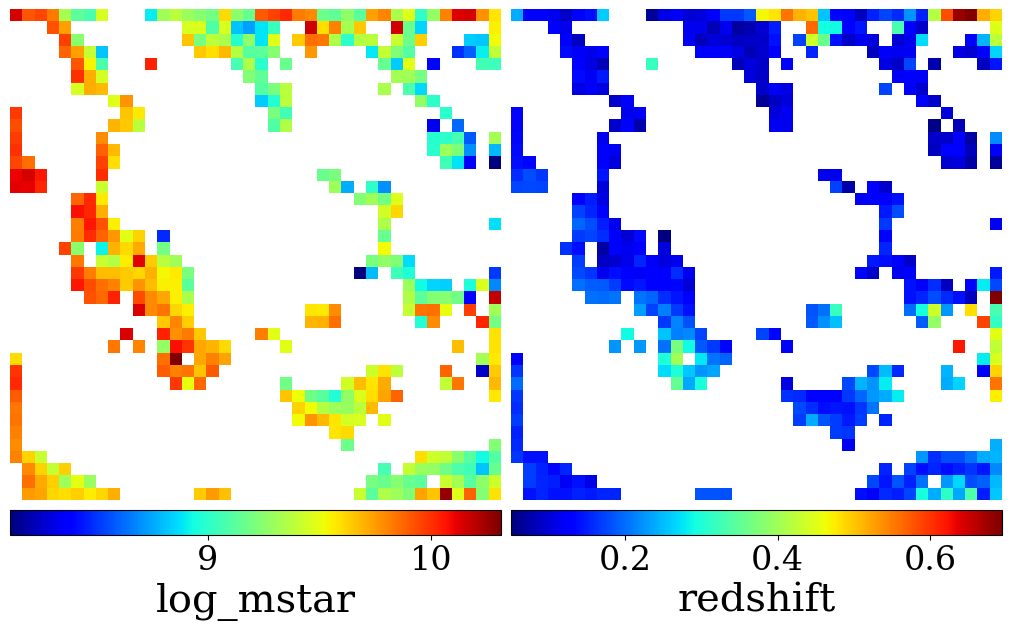

In [64]:
#Label the cells in the map with external parameters. Visualize the labeled map.
# SOM.load_labeling_data(input_labels[-int(data_cut):],

SOM.load_labeling_data(input_labels[randomized_label_idx],
                       parameter_names = ['log_mstar', 'redshift'])
SOM.normalize_labeling_data()

SOM.load_labeling_standard_deviations(input_label_stds[randomized_label_idx])
SOM.normalize_labeling_standard_deviations()

label_map(SOM,
          pdr = 200)

SOM.show_map(show_labeled = True,
             cmap = 'jet')

In [47]:
pdr = 200
labeled_map = np.zeros([*SOM.mapsize, SOM.labels_dim, pdr])

distribution = np.array([np.linspace(np.min(SOM.labeling_data[:, i]), np.max(SOM.labeling_data[:, i]), pdr)\
                        for i in range(SOM.data_dim, SOM.labeling_data_dim)])

AttributeError: 'SelfOrganizingMap' object has no attribute 'labels_dim'

In [62]:
occupied_cells = np.zeros(SOM.mapsize)

for index in range(SOM.data_len):

    bmu_coords = find_bmu_coords(SOM.weights_map,
                                 SOM.data[index, :SOM.data_dim],
                                 SOM.variances[index, :SOM.data_dim])

    occupied_cells[*bmu_coords] += 1

    # for i in range(SOM.labels_dim):
    #     delta_index = np.abs(distribution[i] - SOM.labeling_data[index, SOM.data_dim + i]).argmin()
    #     labeled_map[*bmu_coords, i, delta_index] += 1

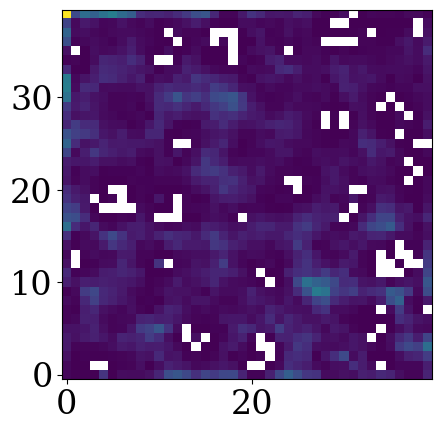

In [63]:
plt.imshow(np.where(occupied_cells > 0, occupied_cells, np.nan),
           origin = 'lower')

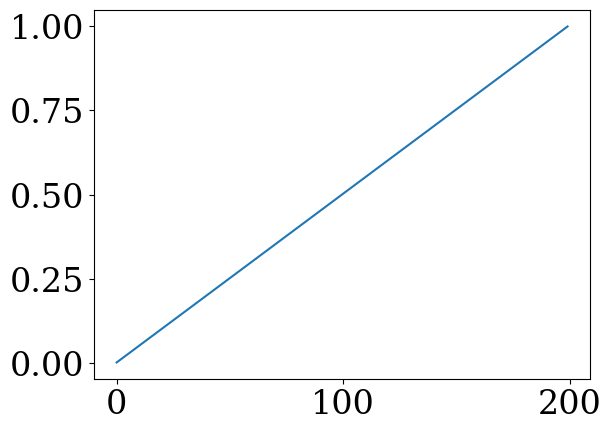

In [26]:
plt.plot(distribution[1])

In [65]:
from mpdg_som_utils import SOM_NeighborhoodFunctions

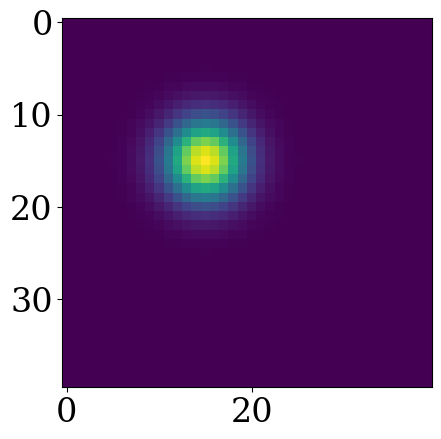

In [67]:
plt.imshow(SOM_NeighborhoodFunctions.gaussian_nbh(1, [15, 15], [40, 40], 5, 10))

In [118]:
step = 1
mean_coordinates = [15, 15]
mapsize = [40, 40]
init_kernel_spread = 5
maximum_steps = 10

linear_nd_space = np.meshgrid(*[np.arange(0, axis) for axis in mapsize])
euclidean_distance_map = np.array([np.abs(linear_nd_space[i] - mean_coordinates[i]) for i in range(len(mapsize))])
euclidean_distance_map = np.sum(euclidean_distance_map**2, axis = 0)

kernel_spread = init_kernel_spread ** (1 - (step/maximum_steps))

gaussian_distance = np.exp(-(euclidean_distance_map)/(kernel_spread**2))

In [114]:
old_gaussian_distance = SOM_NeighborhoodFunctions.gaussian_nbh(1, [15, 15], [40, 40], 5, 10)

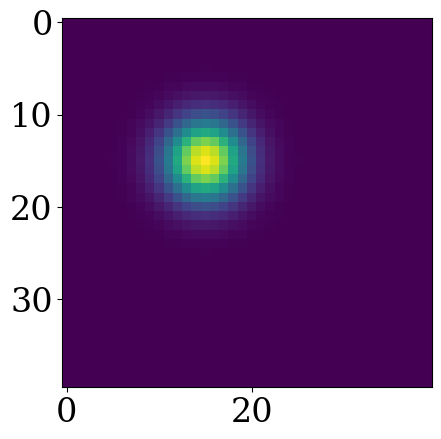

In [119]:
plt.imshow(gaussian_distance)

In [98]:
distance = np.array([np.abs(euclidean_distance_map[i] - [30, 1][i]) for i in range(2)])

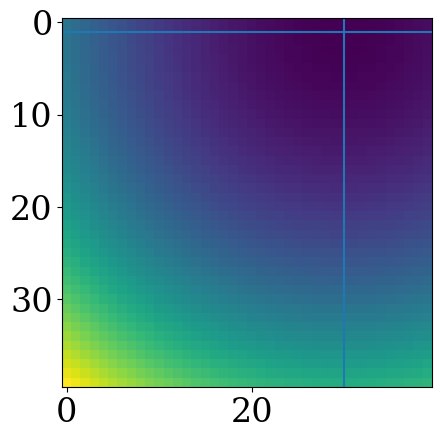

In [100]:
plt.imshow(np.sum(distance ** 2, axis = 0))
plt.axvline(30)
plt.axhline(1)

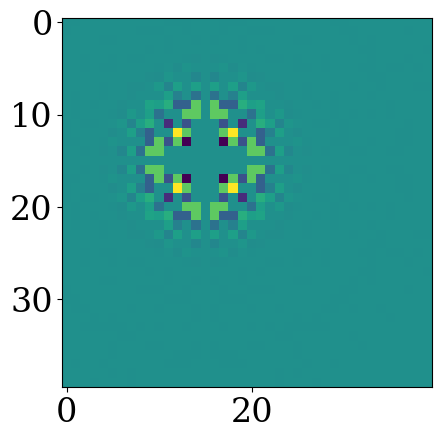

In [120]:
plt.imshow(old_gaussian_distance - gaussian_distance)

In [122]:
np.max(old_gaussian_distance - gaussian_distance)

1.1102230246251565e-16

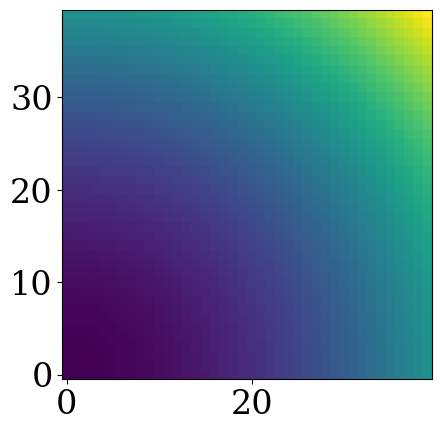

In [86]:
plt.imshow(euclidean_distance_map[0]**2 + euclidean_distance_map[1]**2,
           origin = 'lower')

In [130]:
SOM.weights_map

array([[[0.45904453, 0.8859871 , 0.61724084, 0.42738664],
        [0.465318  , 0.8768038 , 0.61964504, 0.43609308],
        [0.47223655, 0.86355025, 0.62234139, 0.44823474],
        ...,
        [0.80075413, 0.75690709, 0.60945193, 0.48354363],
        [0.82435802, 0.81318505, 0.6020599 , 0.46384397],
        [0.83876485, 0.84810265, 0.59962231, 0.45893774]],

       [[0.45711576, 0.88779325, 0.61502334, 0.42534031],
        [0.46346976, 0.87863878, 0.61724029, 0.43323205],
        [0.46999669, 0.86664381, 0.62012684, 0.44378974],
        ...,
        [0.80270409, 0.76054211, 0.59825127, 0.46292204],
        [0.83195667, 0.80215476, 0.58827971, 0.44012857],
        [0.85156157, 0.82965925, 0.5832985 , 0.43397953]],

       [[0.45250232, 0.89063149, 0.61372663, 0.42218525],
        [0.45795709, 0.88320682, 0.61349555, 0.42700601],
        [0.46369037, 0.87395956, 0.6145169 , 0.43302944],
        ...,
        [0.81494887, 0.78031563, 0.57766599, 0.4302823 ],
        [0.85614217, 0.796424

In [129]:
SOM.weights_map - SOM.data[0]

array([[[ 0.0962124 , -0.00527889,  0.01982951,  0.02012169],
        [ 0.10248588, -0.01446219,  0.02223371,  0.02882813],
        [ 0.10940442, -0.02771574,  0.02493006,  0.04096979],
        ...,
        [ 0.437922  , -0.13435889,  0.01204059,  0.07627868],
        [ 0.46152589, -0.07808094,  0.00464857,  0.05657902],
        [ 0.47593272, -0.04316334,  0.00221098,  0.05167279]],

       [[ 0.09428363, -0.00347273,  0.01761201,  0.01807536],
        [ 0.10063763, -0.01262721,  0.01982895,  0.0259671 ],
        [ 0.10716456, -0.02462218,  0.02271551,  0.03652479],
        ...,
        [ 0.43987196, -0.13072388,  0.00083993,  0.05565709],
        [ 0.46912454, -0.08911123, -0.00913162,  0.03286362],
        [ 0.48872944, -0.06160673, -0.01411284,  0.02671458]],

       [[ 0.08967019, -0.0006345 ,  0.01631529,  0.0149203 ],
        [ 0.09512496, -0.00805917,  0.01608421,  0.01974106],
        [ 0.10085824, -0.01730643,  0.01710557,  0.0257645 ],
        ...,
        [ 0.45211674, -0.11

In [134]:
from mpdg_som_utils import SOM_LearningRateFunctions

In [131]:
current_weight_vectors = SOM.weights_map.copy()

In [132]:
bmu_coords = [15, 20]

In [135]:
SOM_LearningRateFunctions.power_law_lrf(1, 0.095, 10)

0.7902642950786973

In [140]:
neighborhood_mult = SOM_NeighborhoodFunctions.gaussian_nbh(1, [15, 10], [40, 40], 15, 10)
neighborhood_mult = np.stack([neighborhood_mult] * len(SOM.data[0]), axis = -1)

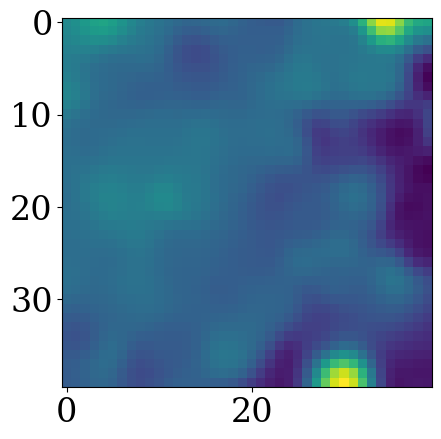

In [148]:
plt.imshow((current_weight_vectors +\
            0.79 * neighborhood_mult *\
            (SOM.data[0] - SOM.weights_map))[..., 3])

In [142]:
(SOM.data[0] - SOM.weights_map) * neighborhood_mult * learning_rate

array([[[-8.03564805e-03,  4.40892141e-04, -1.65615812e-03,
         -1.68056138e-03],
        [-9.89663863e-03,  1.39655386e-03, -2.14701764e-03,
         -2.78381389e-03],
        [-1.20297680e-02,  3.04753623e-03, -2.74123135e-03,
         -4.50491011e-03],
        ...,
        [-2.99526568e-04,  9.18977773e-05, -8.23543215e-06,
         -5.21725154e-05],
        [-2.07380694e-04,  3.50846625e-05, -2.08877439e-06,
         -2.54230533e-05],
        [-1.38361847e-04,  1.25483260e-05, -6.42769668e-07,
         -1.50221710e-05]],

       [[-9.82733385e-03,  3.61968559e-04, -1.83572754e-03,
         -1.88402388e-03],
        [-1.21281239e-02,  1.52174048e-03, -2.38964288e-03,
         -3.12936817e-03],
        [-1.47056111e-02,  3.37876786e-03, -3.11712576e-03,
         -5.01209925e-03],
        ...,
        [-3.75469257e-04,  1.11584287e-04, -7.16957159e-07,
         -4.75082055e-05],
        [-2.63069151e-04,  4.99705583e-05,  5.12070354e-06,
         -1.84288064e-05],
        [-1.773

In [78]:
np.shape(euclidean_distance_map)

(2, 40, 40)